In [111]:
from defs.storage_locs import *
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
from tools.image_extract import read_frame

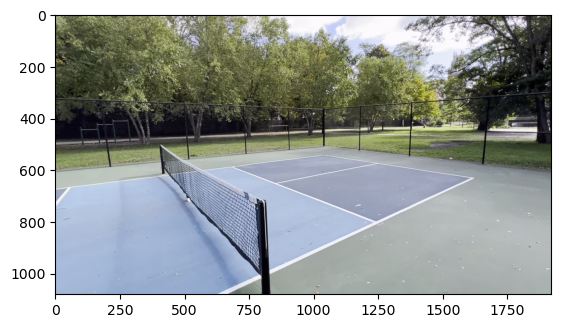

In [130]:
video_type = 'court'
video_name = 'center_right_1'
frame_num = 100
img_0 = read_frame(raw_video_path(video_type, video_name), frame_num)
plt.imshow(img_0)
plt.show()

/home/billf/miniconda3/envs/CV/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


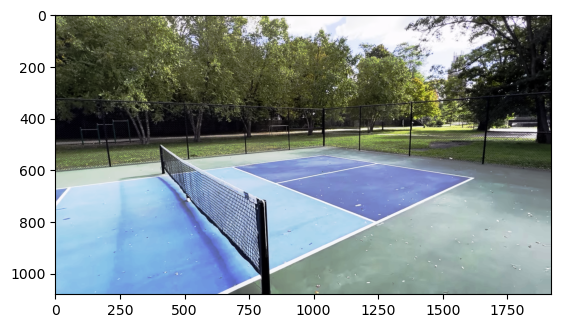

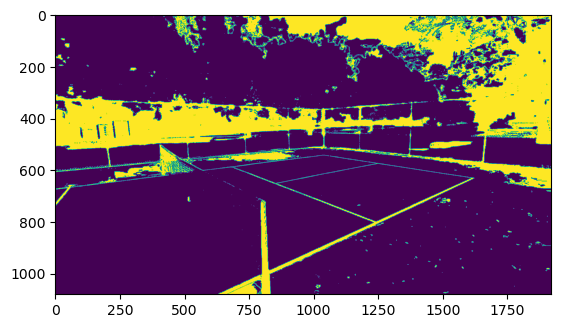

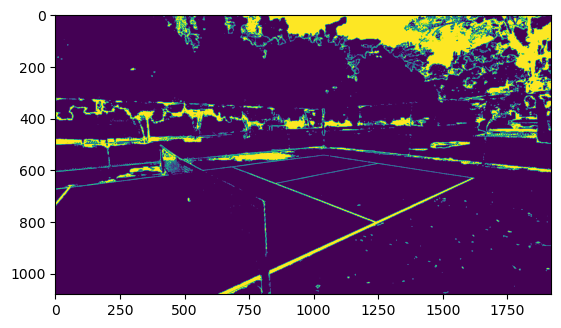

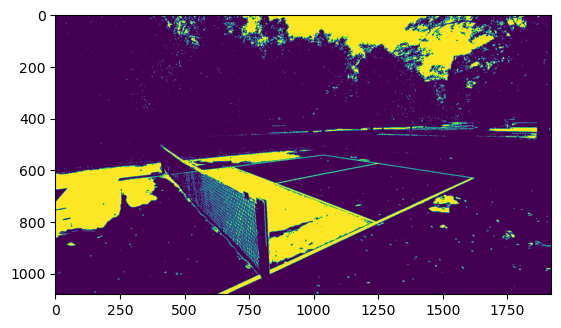

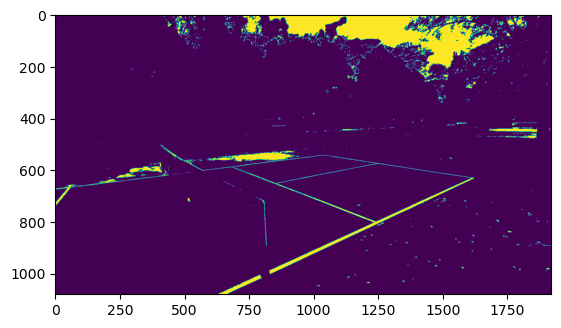

In [131]:
def normalize_image(img):
    normalized = skimage.exposure.equalize_hist(img)
    return normalized

def diff_max_mask(img, threshold = 0.04):
    new_img = img.copy()
    new_img[:,:,0] = np.abs(img[:,:,0] - img[:,:,1])
    new_img[:,:,1] = np.abs(img[:,:,1] - img[:,:,2])
    new_img[:,:,2] = np.abs(img[:,:,2] - img[:,:,0])
    new_img = np.max(new_img, axis=2)
    return new_img <= threshold

def diff_from_avg_mask(img, threshold = 0.01):
    avg = np.mean(img, axis=2)
    diffs = np.square(img - np.expand_dims(avg, axis=2))/(img + 1e-10)
    geom_distance = np.sqrt(np.sum(diffs, axis=2))/3
    return geom_distance <= threshold

def brightness_mask(img, threshold = 0.8):
    brightness = np.mean(img, axis=2)
    return brightness >= threshold
img = normalize_image(img_0)
max_mask = diff_max_mask(img)
avg_mask = diff_from_avg_mask(img)
bright_mask = brightness_mask(img)
total_mask = max_mask * avg_mask * bright_mask
plt.imshow(img)
plt.show()
plt.imshow(max_mask)
plt.show()
plt.imshow(avg_mask)
plt.show()
plt.imshow(bright_mask)
plt.show()
plt.imshow(total_mask)
plt.show()


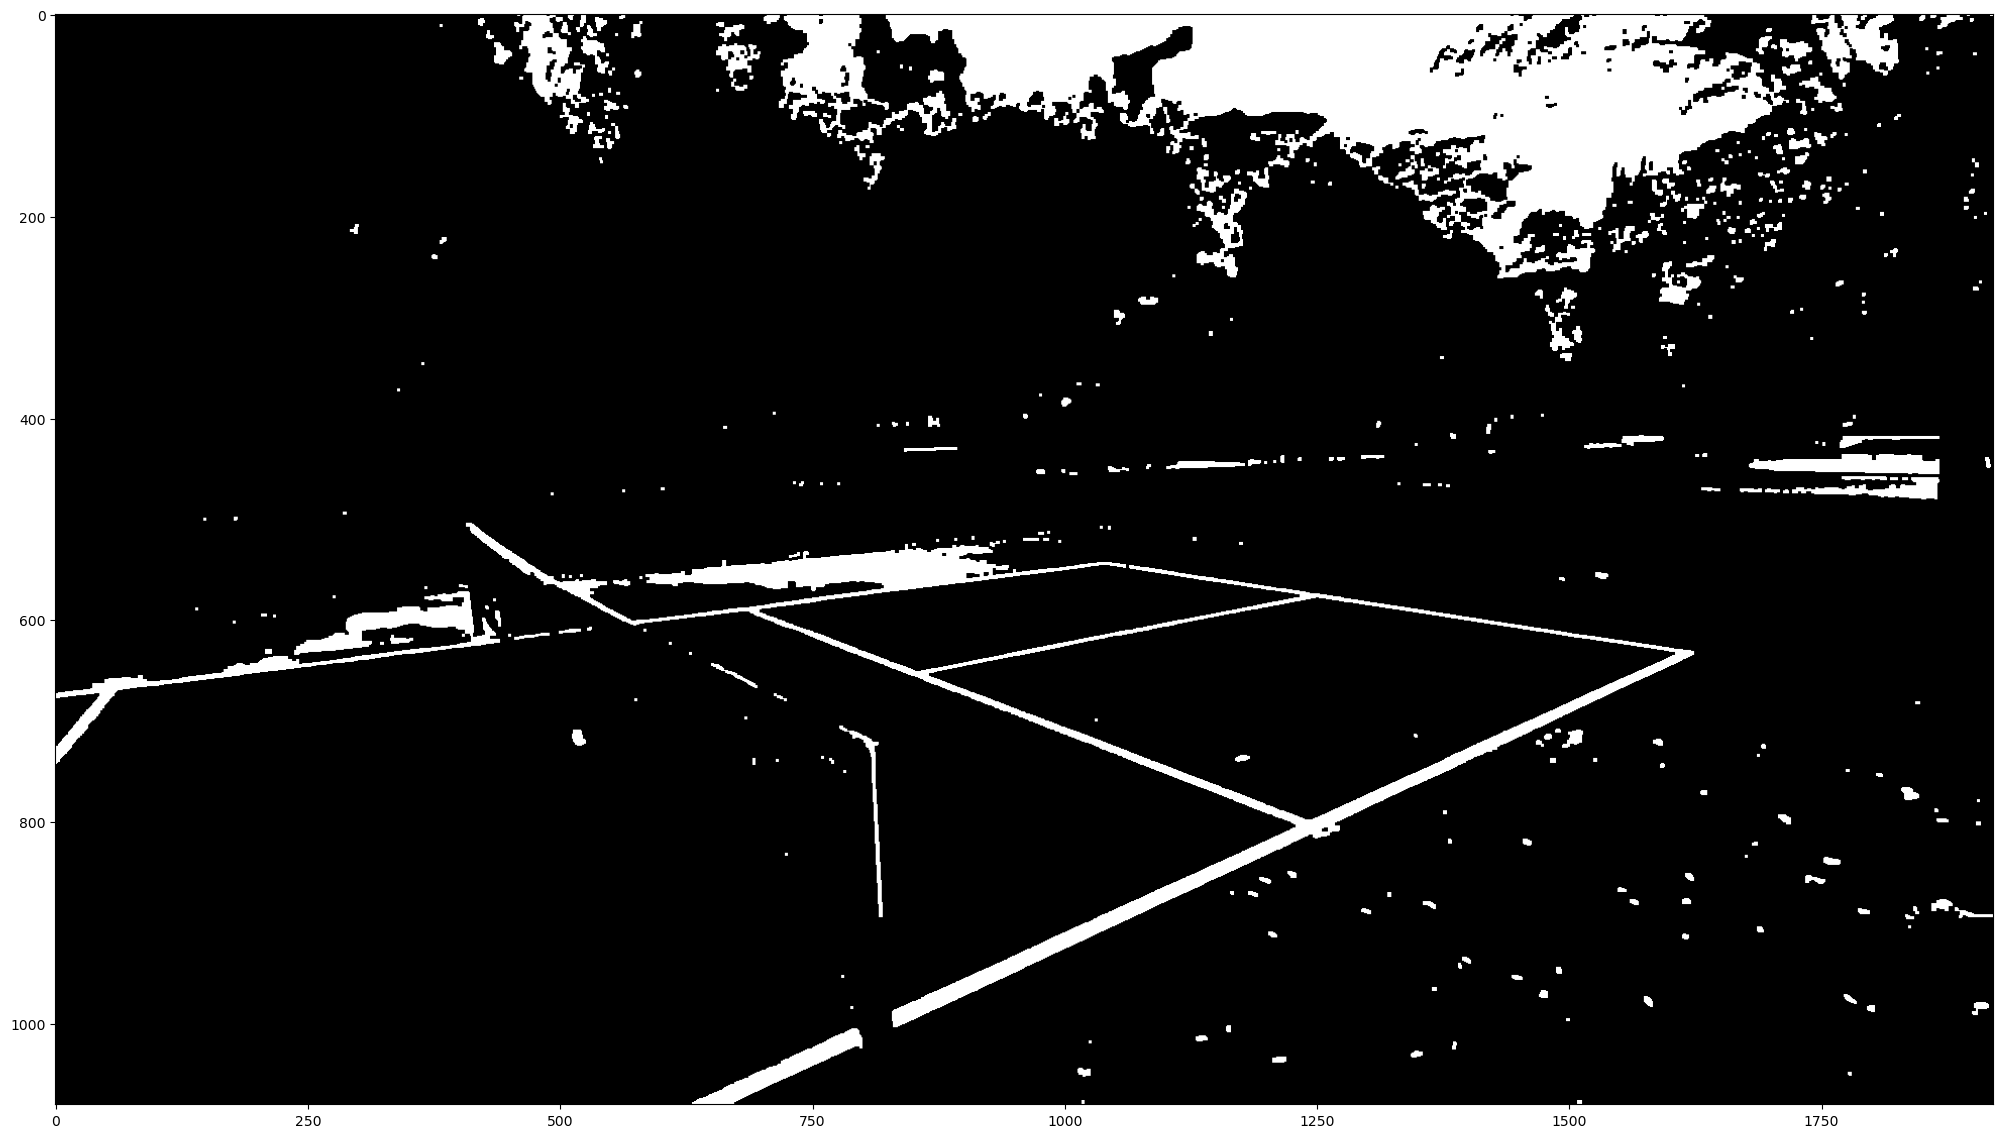

In [114]:
mask = total_mask.copy()
mask = cv2.dilate(mask.astype(np.uint8), np.ones((3,3), np.uint8), iterations=2)
mask = cv2.erode(mask.astype(np.uint8), np.ones((3,3), np.uint8), iterations=1)
mask = cv2.dilate(mask.astype(np.uint8), np.ones((3,3), np.uint8), iterations=1)
mask = cv2.erode(mask.astype(np.uint8), np.ones((3,3), np.uint8), iterations=1)

plt.figure(figsize=(25,25))
plt.imshow(mask, cmap='gray')
plt.show()


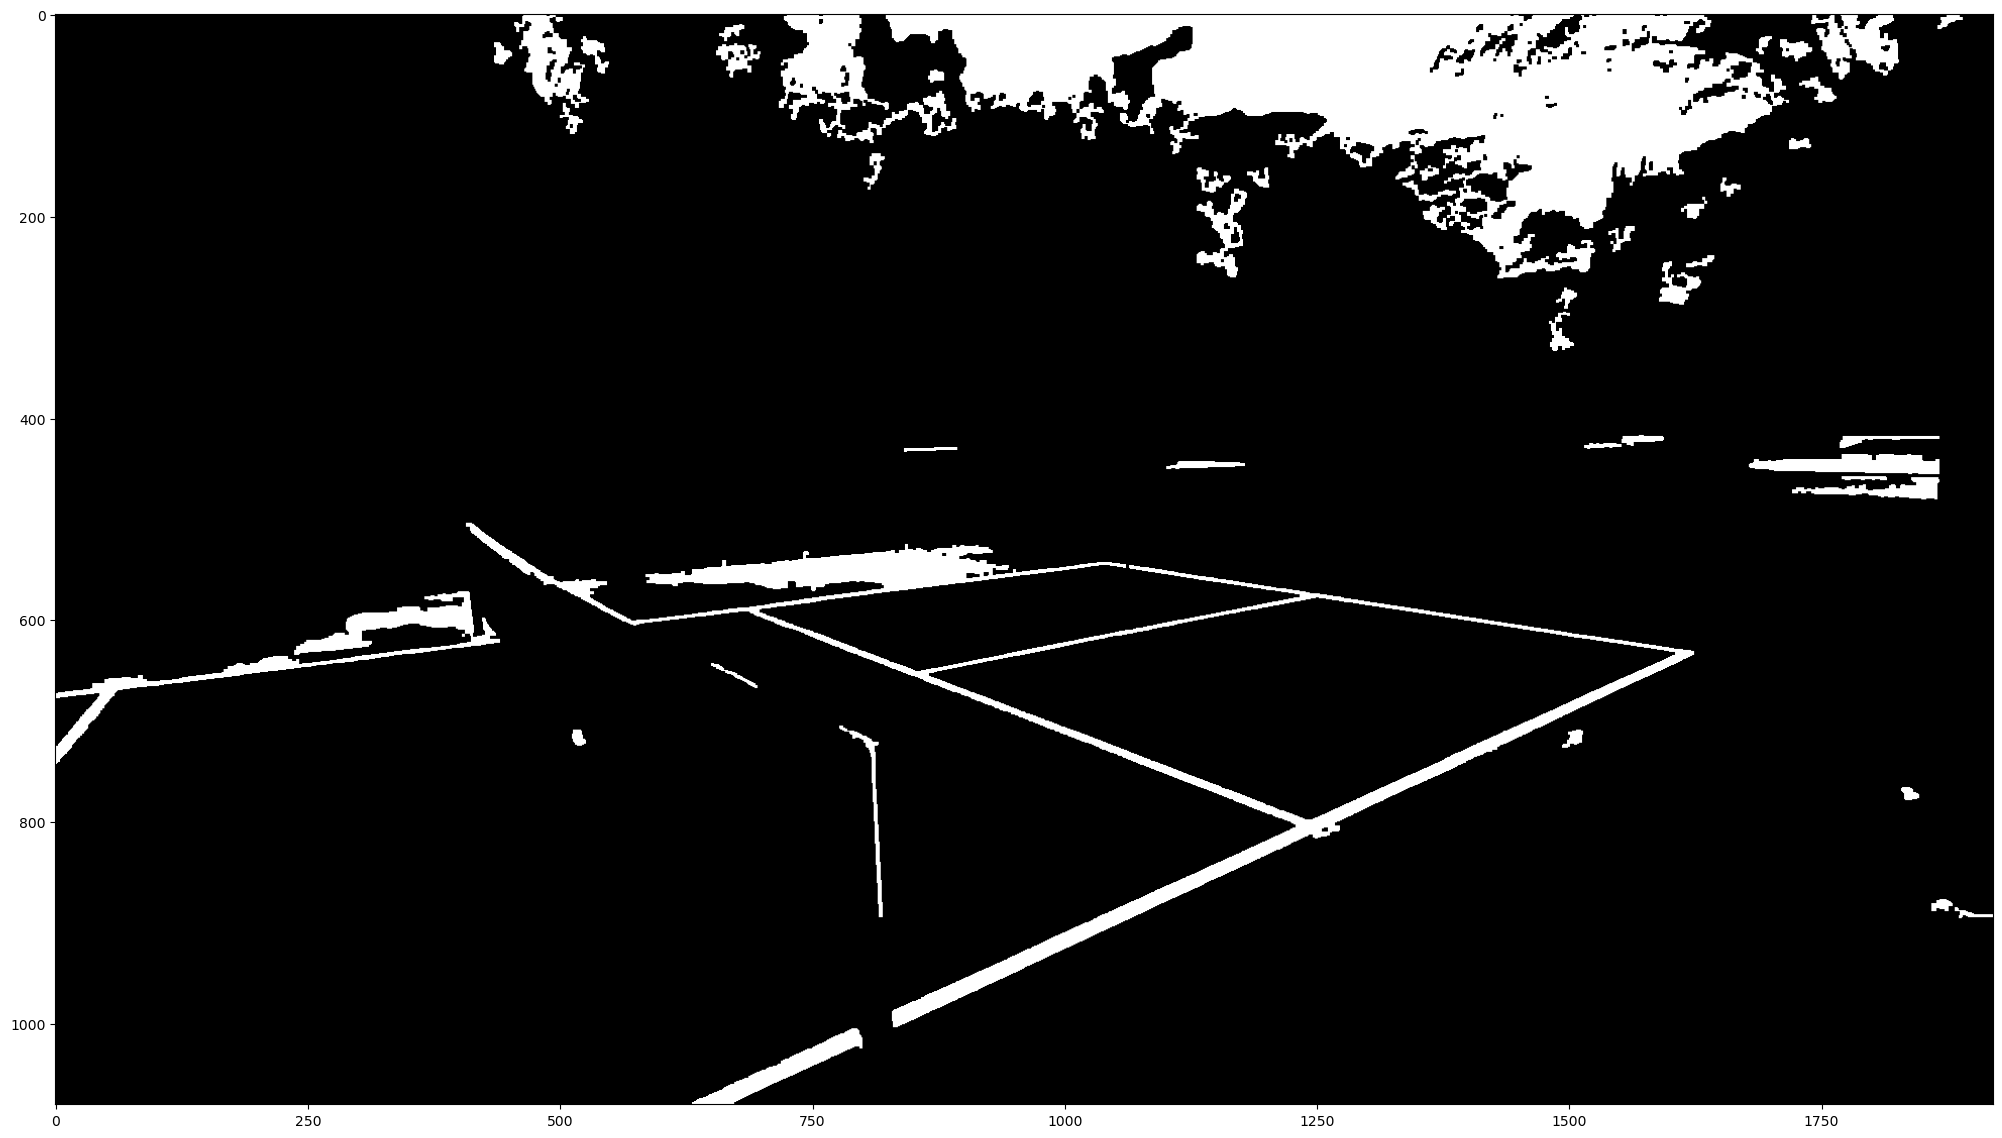

In [115]:
# remove small objects
from skimage import measure
from skimage.morphology import white_tophat, disk, remove_small_objects
new_mask = mask.copy().astype(bool)
footprint = disk(3)
new_mask = remove_small_objects(new_mask, min_size=140, connectivity=2)
plt.figure(figsize=(25,25))
plt.imshow(new_mask, cmap='gray')
plt.show()

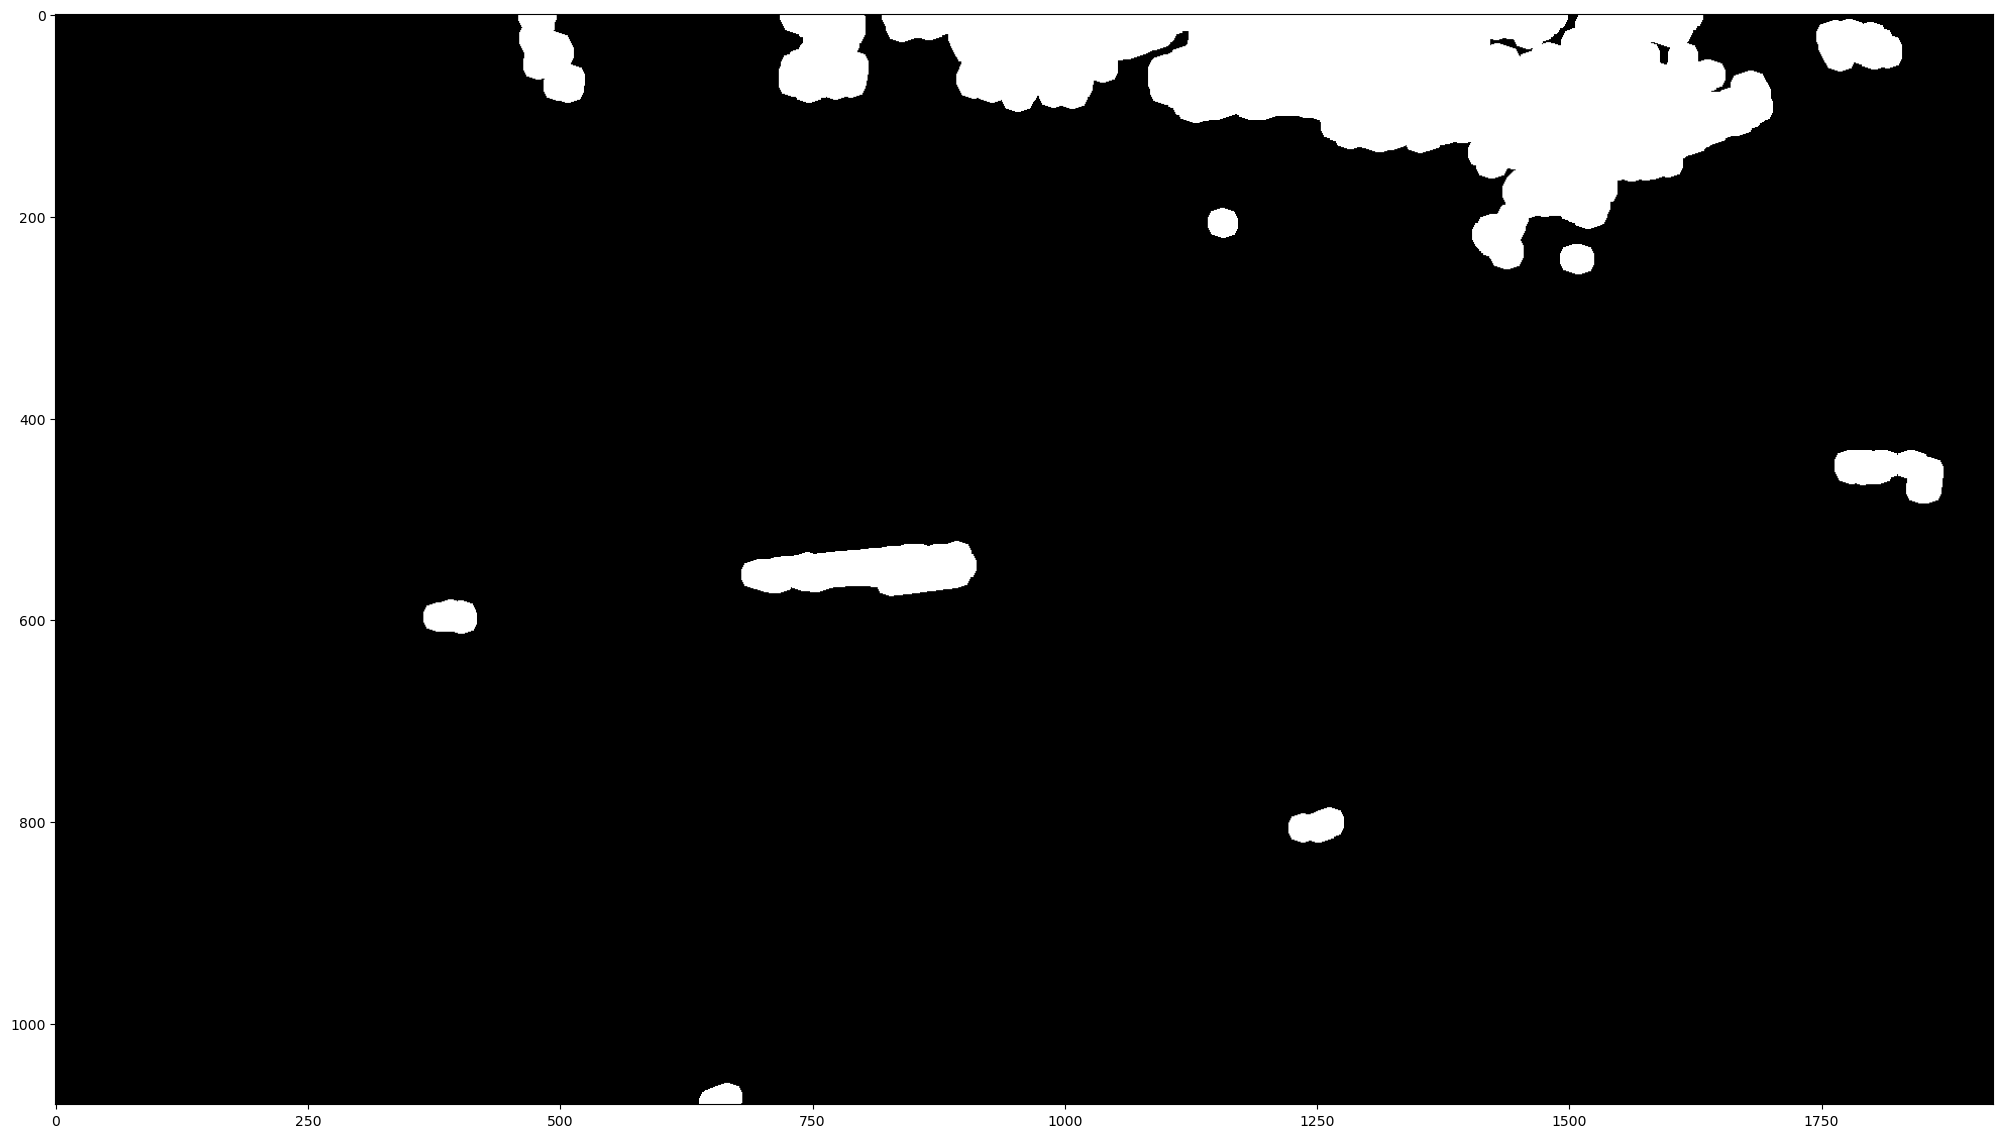

In [116]:
# remove large objects
large_objects = cv2.dilate(new_mask.astype(np.uint8), np.ones((3,3), np.uint8), iterations=2)
circle = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
large_objects = cv2.erode(large_objects.astype(np.uint8), circle, iterations=3)
large_objects = cv2.dilate(large_objects.astype(np.uint8), circle, iterations=3)
large_objects = cv2.dilate(large_objects.astype(np.uint8), np.ones((3,3), np.uint8), iterations=2)
plt.figure(figsize=(25,25))
plt.imshow(large_objects, cmap='gray')
plt.show()


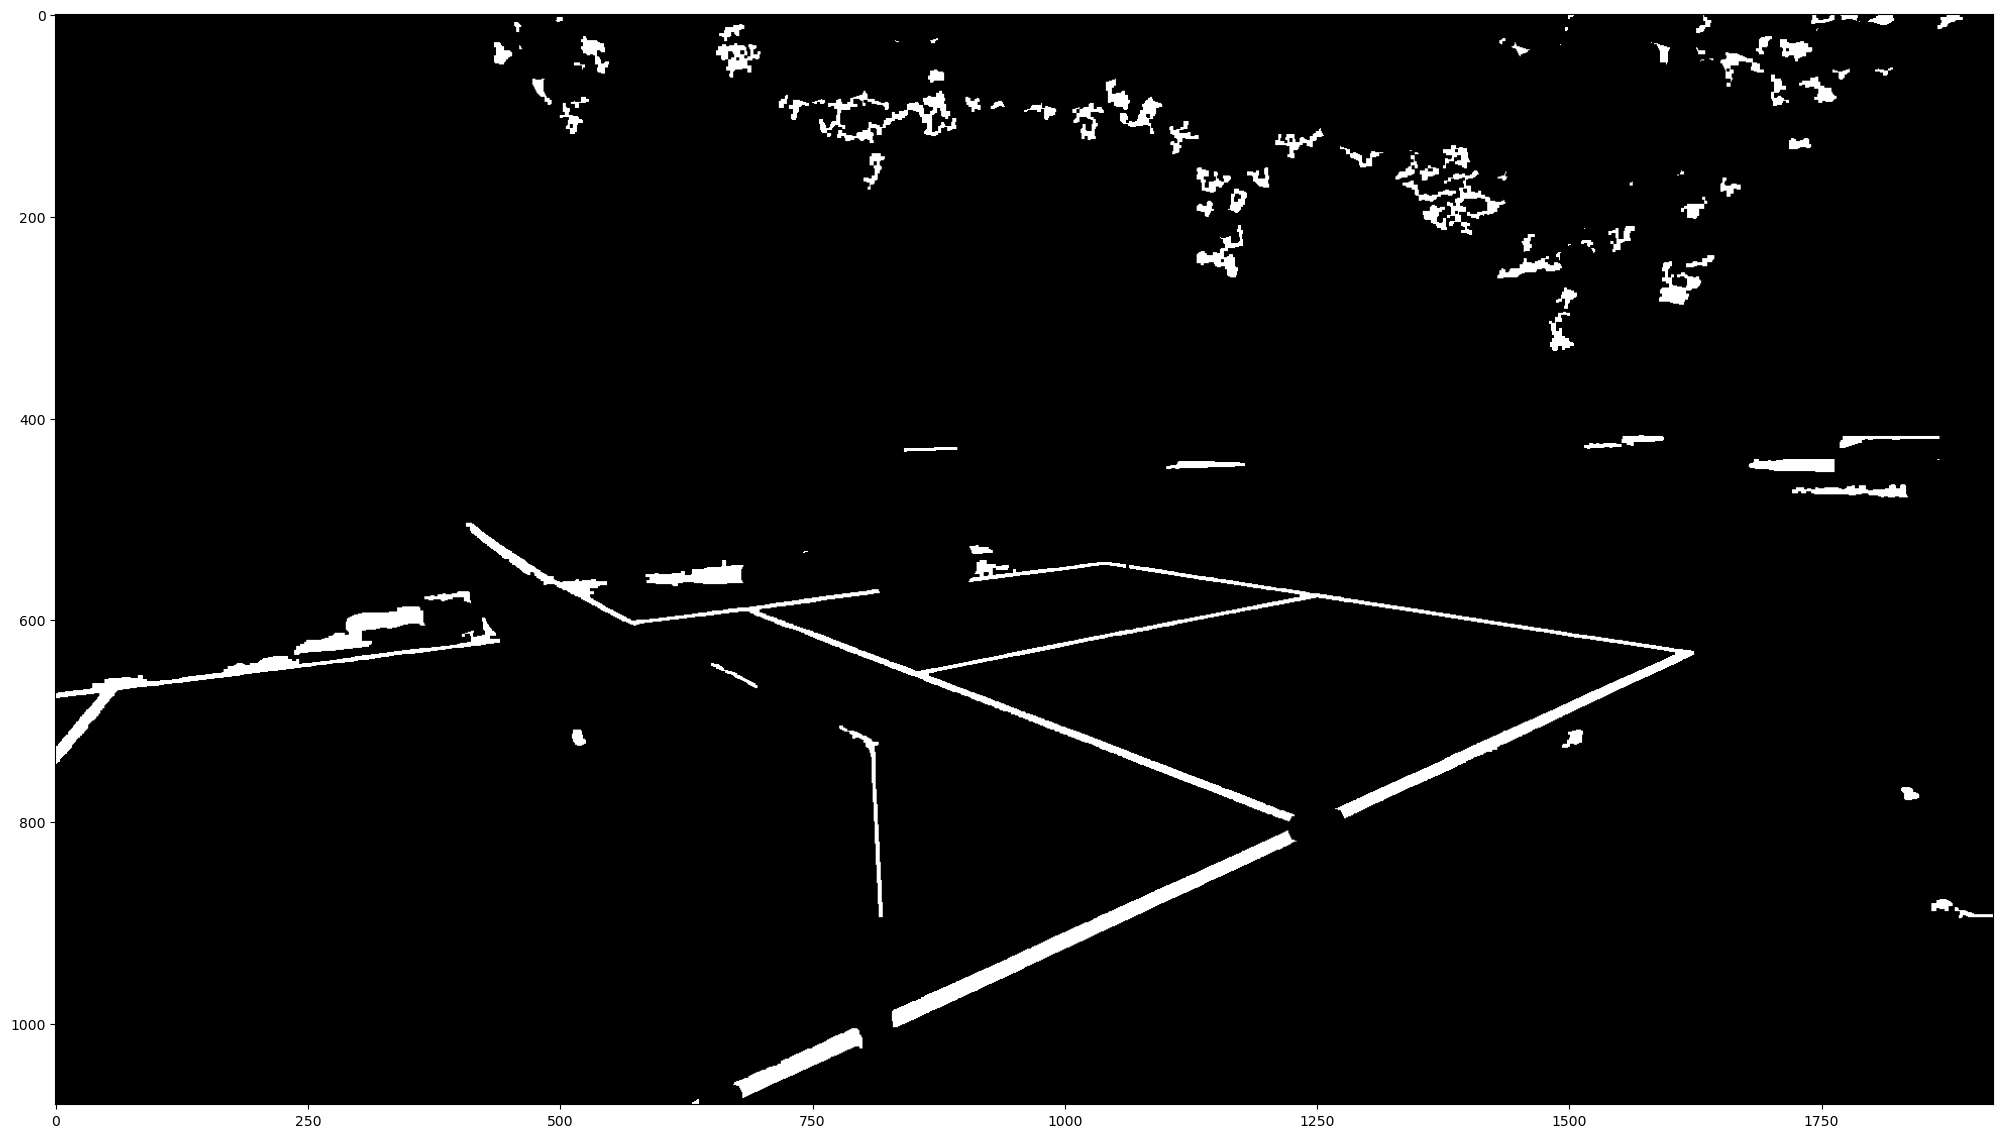

In [117]:
removed_mask = new_mask * (1- large_objects)
plt.figure(figsize=(25,25))
plt.imshow(removed_mask, cmap='gray')
plt.show()


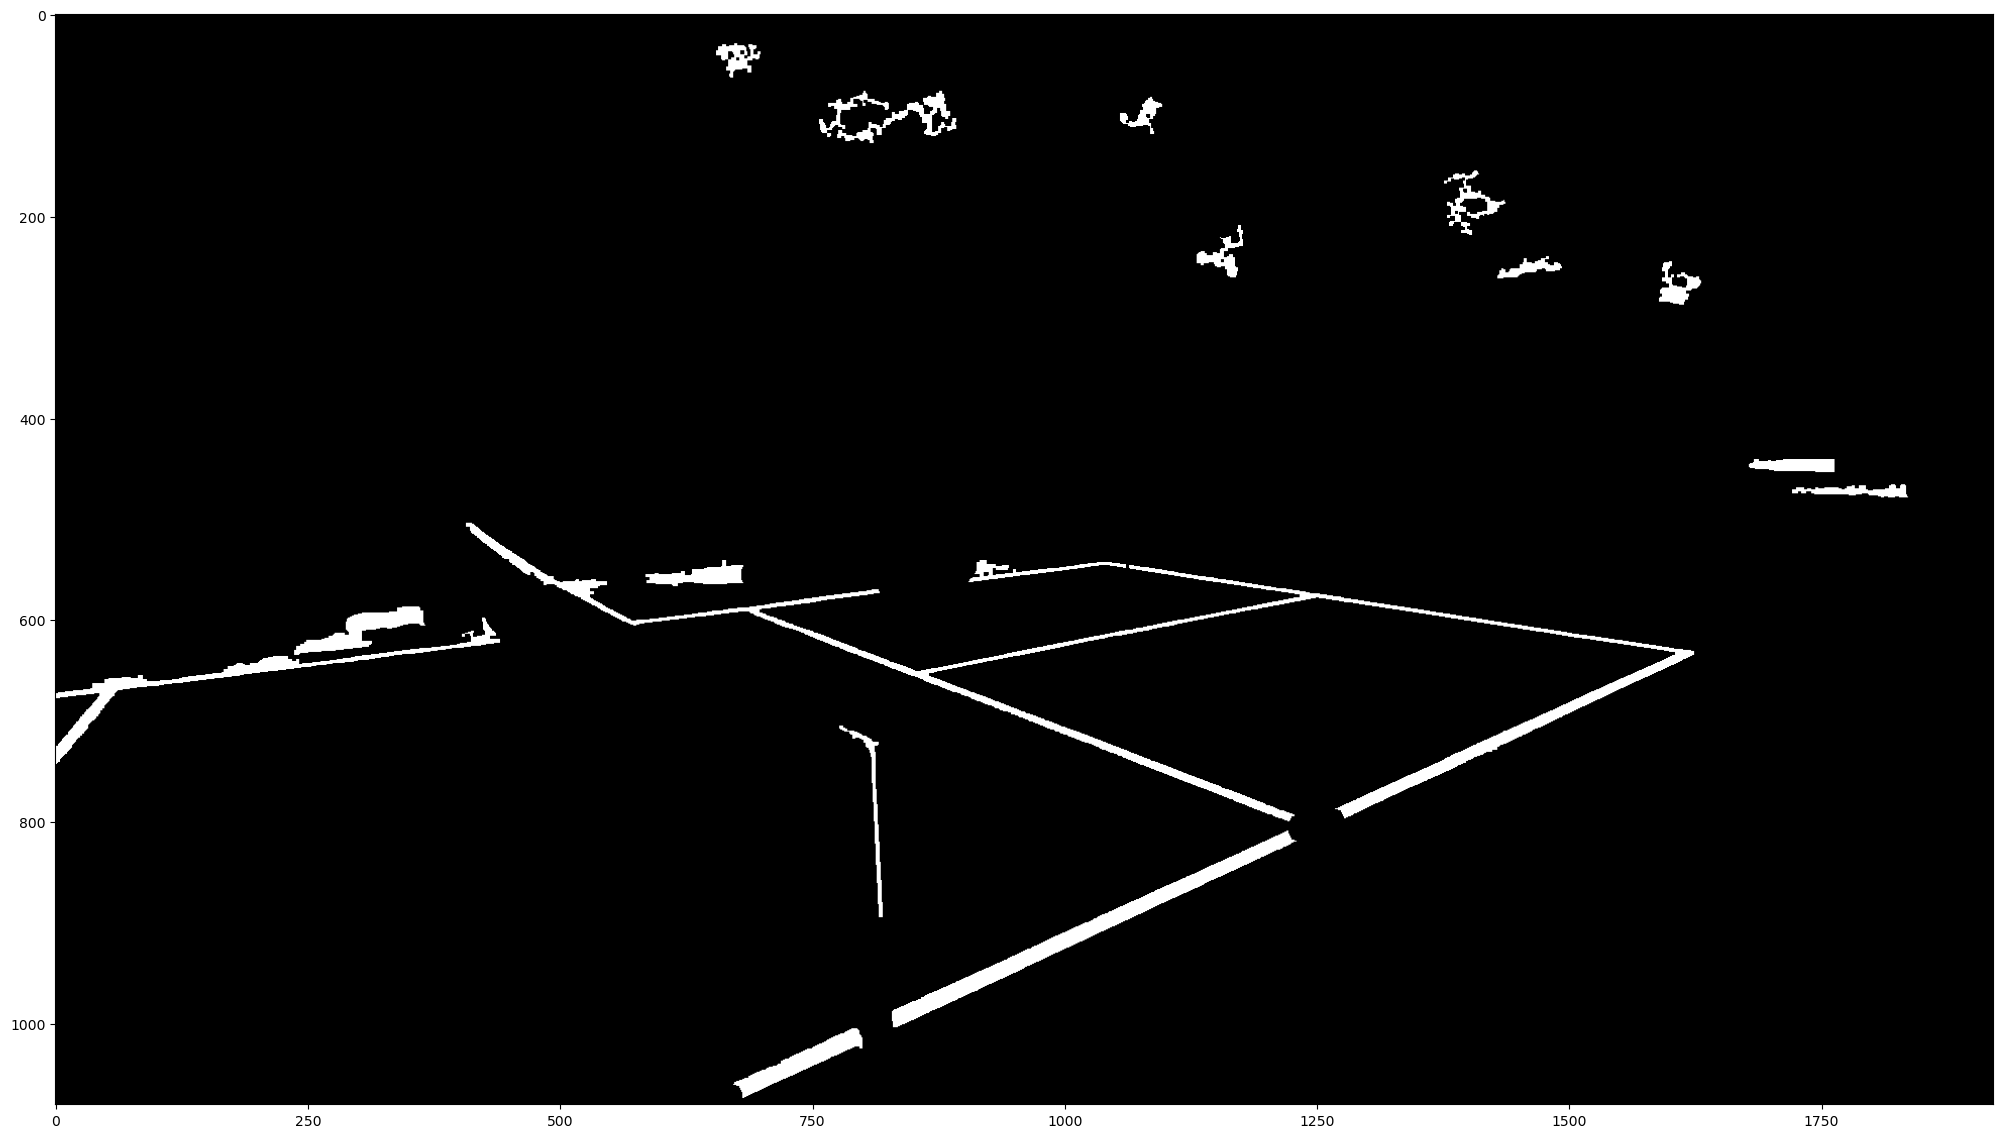

In [129]:
# remove small objects
cleaned = removed_mask.copy().astype(bool)
cleaned = remove_small_objects(cleaned, min_size=500, connectivity=7)
plt.figure(figsize=(25,25))
plt.imshow(cleaned, cmap='gray')
plt.show()


In [119]:
inverse = 1 - mask
inverse = cv2.dilate(inverse.astype(np.uint8), np.ones((5,5), np.uint8), iterations=1)
inverse = 1-inverse
test = cv2.erode(mask.astype(np.uint8), np.ones((5,5), np.uint8), iterations=1)
np.mean(test == inverse)


1.0